<a href="https://colab.research.google.com/github/Zhangdc123/01/blob/main/notebooks/football-ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 足球跟踪

使用计算机视觉和机器学习跟踪球员,并确定所属球队,以及计算足球位置. 使用计算机来分析比赛状态

![football AI diagram](https://github.com/Zhangdc123/01/blob/main/notebooks/football-chn.png?raw=true)

# 一、准备工作

### 获得 API keys

- 复制 [`HuggingFace Settings`](https://huggingface.co/settings)API命名为 `HF_TOKEN`.
- 复制[`Roboflow Settings`](https://app.roboflow.com/settings/api)API命名为 `ROBOFLOW_API_KEY`

In [1]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

###下载依赖项

**Note:**  版本报错可忽略

In [2]:
!pip install -q gdown inference-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 

###调用github上训练好的模型

In [3]:
!pip install -q git+https://github.com/roboflow/sports.git

  Preparing metadata (setup.py) ... done


###从 [DFL - Bundesliga Data Shootout](https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout) 下载测试视频



In [5]:
!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: /content/0bfacc_0.mp4
100% 19.9M/19.9M [00:00<00:00, 35.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
To: /content/2e57b9_0.mp4
100% 21.1M/21.1M [00:00<00:00, 41.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
To: /content/08fd33_0.mp4
100% 19.9M/19.9M [00:00<00:00, 35.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU
To: /content/573e61_0.mp4
100% 18.9M/18.9M [00:00<00:00, 41.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu
To: /content/121364_0.mp4
100% 17.2M/17.2M [00:00<00:00, 28.5MB/s]


In [6]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

#二、检测球 运动员 守门员 裁判
- YOLOv8 (检测球员) - 在视频中检测球员, 守门员, 裁判, 以及球.

###调用模型

In [7]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/11"
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

ModelDependencyMissing: Your `inference` configuration does not support SAM3 model. Install SAM3 dependencies and set CORE_MODEL_SAM3_ENABLED to True.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.To suppress this warning, set CORE_MODEL_GAZE_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support YoloWorld model. Use pip install 'inference[yolo-world]' to install missing requirements.To suppress this warning, set CORE_MODEL_YOLO_WORLD_ENABLED to False.


Resolved model_id: football-players-detection-3zvbc/11, dataset_id: football-players-detection-3zvbc, version_id: 11


###展示视频

In [ ]:
from IPython.display import HTML
from base64 import b64encode

video_name = "573e61_0.mp4"

mp4 = open(video_name, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=600 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")

###生成检测物体的视频
**Note:用矩形标记物体 用颜色区分类别 会显示分类和置信度**

In [12]:
from tqdm import tqdm
import supervision as sv

SOURCE_VIDEO_PATH = "/content/573e61_0.mp4"
TARGET_VIDEO_PATH = "/content/573e61_0_result_1.mp4"

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]#找出置信度大于0.3的目标
        detections = sv.Detections.from_inference(result)

        labels = [
            f"{class_name} {confidence:.2f}"
            for class_name, confidence
            in zip(detections['class_name'], detections.confidence)
        ]

        annotated_frame = frame.copy()
        annotated_frame = box_annotator.annotate(annotated_frame, detections)
        annotated_frame = label_annotator.annotate(annotated_frame, detections, labels=labels)
        video_sink.write_frame(annotated_frame)

100%|██████████| 750/750 [03:51<00:00,  3.24it/s]


###不同风格的展示
**Note:椭圆标记球员 三角形标记球 不显示类别和置信度**

In [ ]:
import supervision as sv
from tqdm import tqdm

SOURCE_VIDEO_PATH = "/content/573e61_0.mp4"
TARGET_VIDEO_PATH = "/content/573e61_0_result_style.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25, height=21, outline_thickness=1
)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        # 分离球和人，但仅为了使用不同的标注器
        ball_detections = detections[detections.class_id == BALL_ID]
        person_detections = detections[detections.class_id != BALL_ID]

        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=person_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
        sink.write_frame(annotated_frame)

100%|██████████| 750/750 [03:36<00:00,  3.46it/s]


**精细化处理**

去重优化(NMS):模型可能会对同一个球员产生两个重叠的判断。NMS把重叠的假信号滤掉，确保一个人对应一个环。

身份对齐(ID Offset):解决模型索引带来的颜色错位问题。通过手动平移ID防止闪烁感。

In [18]:
import supervision as sv
import numpy as np
from tqdm import tqdm

SOURCE_VIDEO_PATH = "/content/573e61_0.mp4"
TARGET_VIDEO_PATH = "/content/573e61_0_result_logic.mp4"

BALL_ORIGINAL_ID = 0        l
BALL_DRAW_ID = 3

# class_id 对应关系（绘制用）
# 0 = Player
# 1 = Goalkeeper
# 2 = Referee
# 3 = Ball
box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex([
        '#FF8C00',  # Player
        '#00BFFF',  # Goalkeeper
        '#FF1493',  # Referee
        '#FFD700'   # Ball
    ]),
    thickness=2
)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        ball_detections = detections[detections.class_id == BALL_ORIGINAL_ID]

        if len(ball_detections) > 0:
            ball_detections.xyxy = sv.pad_boxes(
                xyxy=ball_detections.xyxy,
                px=10
            )
            ball_detections.class_id = np.full(
                len(ball_detections),
                BALL_DRAW_ID,
                dtype=int
            )

        person_detections = detections[detections.class_id != BALL_ORIGINAL_ID]
        person_detections = person_detections.with_nms(
            threshold=0.5,
            class_agnostic=True
        )

        person_detections.class_id = person_detections.class_id - 1
        refined_detections = sv.Detections.merge(
            [person_detections, ball_detections]
        )

        annotated_frame = frame.copy()
        annotated_frame = box_annotator.annotate(
            scene=annotated_frame,
            detections=refined_detections
        )

        sink.write_frame(annotated_frame)


100%|██████████| 750/750 [03:50<00:00,  3.26it/s]


**引入ByteTrack追踪器**

In [19]:
import supervision as sv
import numpy as np
from tqdm import tqdm

SOURCE_VIDEO_PATH = "/content/573e61_0.mp4"
TARGET_VIDEO_PATH = "/content/573e61_0_result_track.mp4"

BALL_ID = 0

# =========================
# 显示用 class_id 约定
# 0 = Player      (蓝)
# 1 = Goalkeeper  (红)
# 2 = Referee     (绿)
# =========================

# 模型原始 class_id -> 显示用 class_id
CLASS_ID_MAP = {
    2: 0,  # Player
    1: 1,  # Goalkeeper
    3: 2   # Referee
}

group_palette = sv.ColorPalette.from_hex([
    '#00BFFF',  # Player
    '#FF1493',  # Goalkeeper
    '#00FF00'   # Referee
])

ellipse_annotator = sv.EllipseAnnotator(
    color=group_palette,
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color=group_palette,
    text_color=sv.Color.BLACK,
    text_position=sv.Position.BOTTOM_CENTER,
    text_scale=0.5
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=22
)

tracker = sv.ByteTrack()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # 推理
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)

        # --------------------
        # 球
        # --------------------
        ball_detections = detections[detections.class_id == BALL_ID]

        # --------------------
        # 人（球员 / 守门员 / 裁判）
        # --------------------
        person_detections = detections[detections.class_id != BALL_ID]
        person_detections = person_detections.with_nms(threshold=0.5)

        # ✅ 显式 class_id 映射（关键修正）
        person_detections.class_id = np.array([
            CLASS_ID_MAP.get(cls_id, -1)
            for cls_id in person_detections.class_id
        ])

        # --------------------
        # 追踪
        # --------------------
        person_detections = tracker.update_with_detections(
            detections=person_detections
        )

        # --------------------
        # 标签
        # --------------------
        class_map = {
            0: "Player",
            1: "Goalkeeper",
            2: "Referee"
        }

        labels = [
            f"{class_map.get(cls_id, 'Person')} #{trk_id}"
            for cls_id, trk_id in zip(
                person_detections.class_id,
                person_detections.tracker_id
            )
        ]

        # --------------------
        # 渲染
        # --------------------
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(
            annotated_frame,
            person_detections
        )
        annotated_frame = label_annotator.annotate(
            annotated_frame,
            person_detections,
            labels=labels
        )
        annotated_frame = triangle_annotator.annotate(
            annotated_frame,
            ball_detections
        )

        sink.write_frame(annotated_frame)


100%|██████████| 750/750 [03:53<00:00,  3.21it/s]


#三、将球员分队

![football AI diagram](https://media.roboflow.com/notebooks/examples/football-ai-team-clustering.png)

**Note:** 每秒采样一帧并收集球员的切片

collecting crops: 25it [00:13,  1.83it/s]


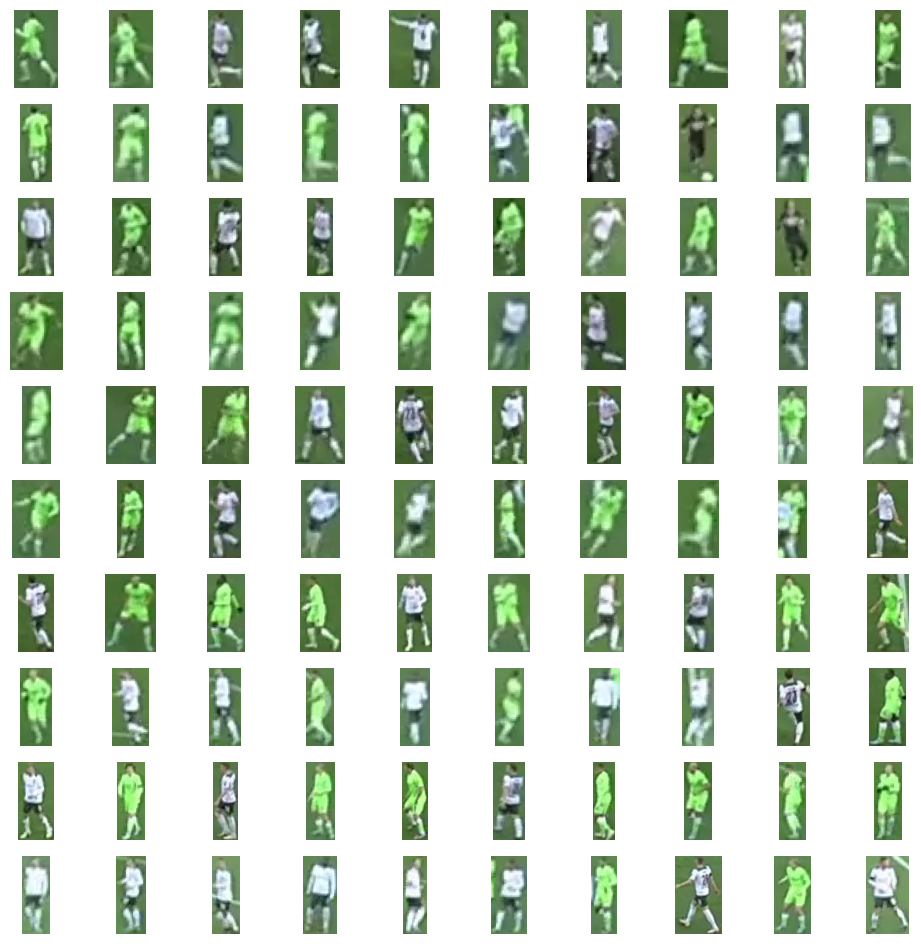

In [ ]:
from tqdm import tqdm

SOURCE_VIDEO_PATH = "/content/08fd33_0.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

**Note:** 现在通过 [SigLIP](https://huggingface.co/docs/transformers/en/model_doc/siglip) 将图片转化为768维数字向量

In [ ]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [ ]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 16it [00:07,  2.25it/s]


**Note:** 使用 [UMAP](https://github.com/lmcinnes/umap), 降维将768维降低为3维再使用 [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)分为两队

In [ ]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [ ]:
projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

**Note:** 可视化结果，点击显示原图

In [ ]:
import plotly.graph_objects as go
import numpy as np
from typing import Dict, List
from IPython.core.display import display, HTML
from PIL import Image
import base64
from io import BytesIO


def pil_image_to_data_uri(image: Image.Image) -> str:
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_str}"


def display_projections(
    labels: np.ndarray,
    projections: np.ndarray,
    images: List[Image.Image],
    show_legend: bool = False,
    show_markers_with_text: bool = True
) -> None:
    image_data_uris = {f"image_{i}": pil_image_to_data_uri(image) for i, image in enumerate(images)}
    image_ids = np.array([f"image_{i}" for i in range(len(images))])

    unique_labels = np.unique(labels)
    traces = []
    for unique_label in unique_labels:
        mask = labels == unique_label
        customdata_masked = image_ids[mask]
        trace = go.Scatter3d(
            x=projections[mask][:, 0],
            y=projections[mask][:, 1],
            z=projections[mask][:, 2],
            mode='markers+text' if show_markers_with_text else 'markers',
            text=labels[mask],
            customdata=customdata_masked,
            name=str(unique_label),
            marker=dict(size=8),
            hovertemplate="<b>class: %{text}</b><br>image ID: %{customdata}<extra></extra>"
        )
        traces.append(trace)

    # Calculate shared range for cube appearance
    all_axes = projections
    min_val = np.min(all_axes)
    max_val = np.max(all_axes)
    padding = (max_val - min_val) * 0.05
    axis_range = [min_val - padding, max_val + padding]

    fig = go.Figure(data=traces)
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='X', range=axis_range),
            yaxis=dict(title='Y', range=axis_range),
            zaxis=dict(title='Z', range=axis_range),
            aspectmode='cube'  # Ensures equal scaling
        ),
        width=1000,
        height=1000,
        showlegend=show_legend
    )

    plotly_div = fig.to_html(full_html=False, include_plotlyjs=False, div_id="scatter-plot-3d")

    javascript_code = f"""
    <script>
        function displayImage(imageId) {{
            var imageElement = document.getElementById('image-display');
            var placeholderText = document.getElementById('placeholder-text');
            var imageDataURIs = {image_data_uris};
            imageElement.src = imageDataURIs[imageId];
            imageElement.style.display = 'block';
            placeholderText.style.display = 'none';
        }}

        var chartElement = document.getElementById('scatter-plot-3d');

        chartElement.on('plotly_click', function(data) {{
            var customdata = data.points[0].customdata;
            displayImage(customdata);
        }});
    </script>
    """

    html_template = f"""
    <!DOCTYPE html>
    <html>
        <head>
            <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
            <style>
                #image-container {{
                    position: fixed;
                    top: 0;
                    left: 0;
                    width: 200px;
                    height: 200px;
                    padding: 5px;
                    border: 1px solid #ccc;
                    background-color: white;
                    z-index: 1000;
                    box-sizing: border-box;
                    display: flex;
                    align-items: center;
                    justify-content: center;
                    text-align: center;
                }}
                #image-display {{
                    width: 100%;
                    height: 100%;
                    object-fit: contain;
                }}
            </style>
        </head>
        <body>
            {plotly_div}
            <div id="image-container">
                <img id="image-display" src="" alt="Selected image" style="display: none;" />
                <p id="placeholder-text">Click on a data entry to display an image</p>
            </div>
            {javascript_code}
        </body>
    </html>
    """

    display(HTML(html_template))

display_projections(clusters, projections, crops)

###为了简化 SigLIP, UMAP, 和 KMeans, 调用了打包好的 [`TeamClassifier`](https://github.com/roboflow/sports/blob/06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1/sports/common/team.py#L41)模型 可以在 [sports](https://github.com/roboflow/sports) 中找到.

In [ ]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier
SOURCE_VIDEO_PATH = "/content/08fd33_0.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 25it [00:14,  1.77it/s]
Embedding extraction: 19it [00:08,  2.32it/s]


**Note:** 为守门员添加队伍标签. 计算队伍的平均位置将守门员就近分配

In [ ]:
import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

###生成分队后的视频

In [ ]:
from tqdm import tqdm
import contextlib
import io

TARGET_VIDEO_PATH = "/content/08fd33_0_result_4.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

f = io.StringIO()

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    # 外部的主进度条
    for frame in tqdm(frame_generator, total=video_info.total_frames, desc='Processing Video'):

        # 使用 contextlib 将 stdout 和 stderr 重定向到我们创建的 StringIO 对象 f 中
        with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
            detections = sv.Detections.from_inference(result)

            ball_detections = detections[detections.class_id == BALL_ID]
            ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

            all_detections = detections[detections.class_id != BALL_ID]
            all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
            all_detections = tracker.update_with_detections(detections=all_detections)

            goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
            players_detections = all_detections[all_detections.class_id == PLAYER_ID]
            referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

            if len(players_detections) > 0:
                players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
                # 这里的 predict 内部进度条也会被吸入 f 中
                players_detections.class_id = team_classifier.predict(players_crops)

        # 逻辑继续
        if len(goalkeepers_detections) > 0:
            goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

        referees_detections.class_id -= 1
        all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])

        labels = [f"#{tid}" for tid in all_detections.tracker_id] if all_detections.tracker_id is not None else []
        all_detections.class_id = all_detections.class_id.astype(int)

        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=all_detections, labels=labels)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)

        sink.write_frame(annotated_frame)

print(f"\n处理完成！视频保存在: {TARGET_VIDEO_PATH}")

#四、球场关键点检测

In [ ]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

Resolved model_id: football-field-detection-f07vi/14, dataset_id: football-field-detection-f07vi, version_id: 14


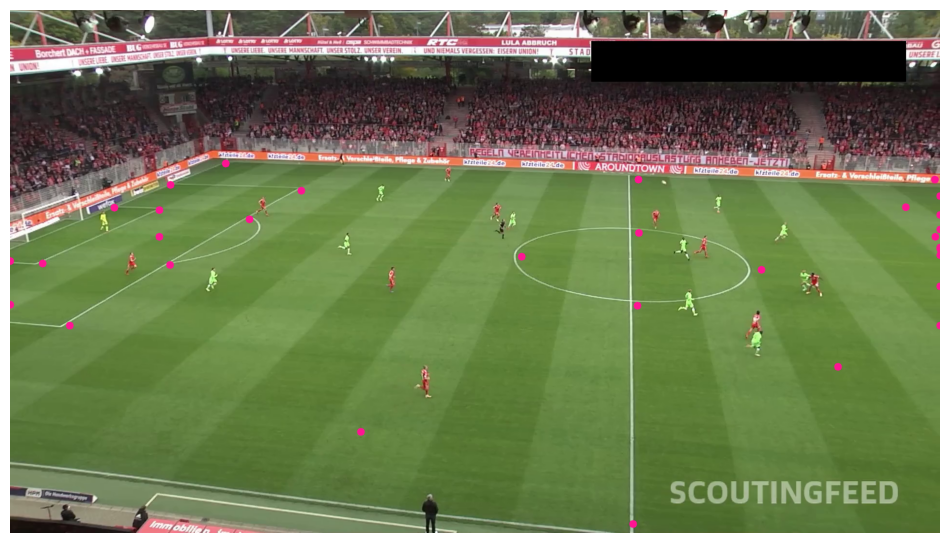

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

**Note:** 过滤低置信度的点

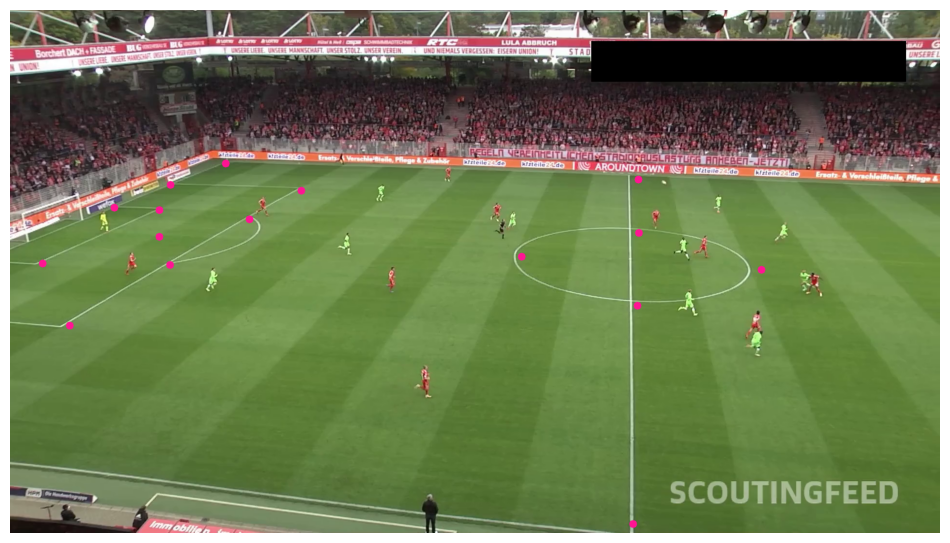

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

## project pitch lines on frame

**Note:** 调用[sports](https://github.com/roboflow/sports)里的[`SoccerPitchConfiguration`](https://github.com/roboflow/sports/blob/06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1/sports/configs/soccer.py#L6) 生成标准足球场

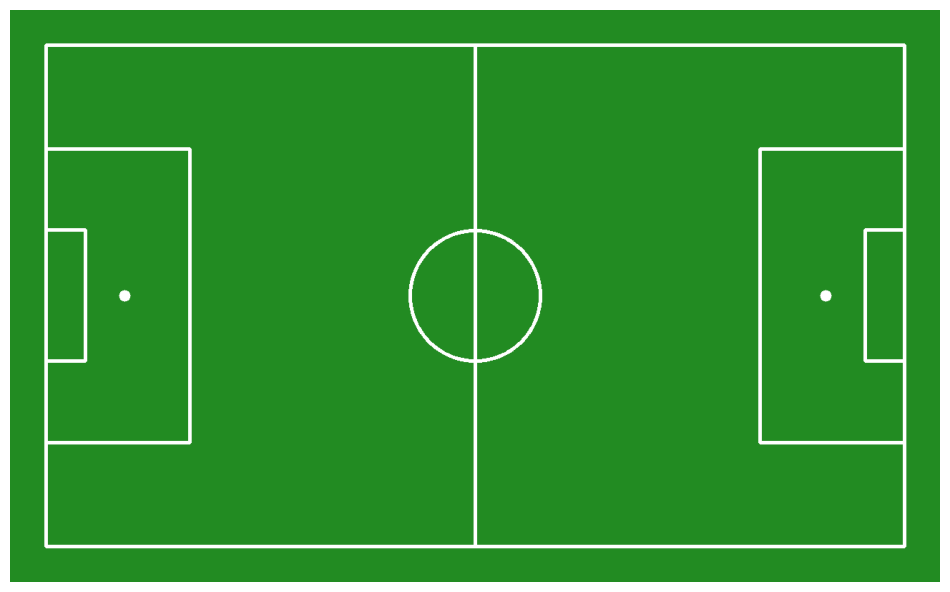

In [ ]:
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

**Note:** 将标准足球场投影到视频中[sports](https://github.com/roboflow/sports) 提供了所需工具 [`ViewTransformer`](https://github.com/roboflow/sports/blob/06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1/sports/common/view.py#L7)

In [ ]:
import numpy as np
import supervision as sv
from tqdm.notebook import tqdm
import contextlib
from sports.common.view import ViewTransformer # Import ViewTransformer here

SOURCE_VIDEO_PATH = "/content/08fd33_0.mp4"
TARGET_VIDEO_PATH = "/content/08fd33_0_result_with_pitch.mp4"

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

ellipse_annotator = sv.EllipseAnnotator(color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), thickness=2)
edge_annotator = sv.EdgeAnnotator(color=sv.Color.from_hex('#00BFFF'), thickness=2, edges=CONFIG.edges)

tracker = sv.ByteTrack()
tracker.reset()

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames, desc='Full Video Processing'):

        with contextlib.redirect_stdout(None), contextlib.redirect_stderr(None):
            player_result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
            field_result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]

        detections = sv.Detections.from_inference(player_result)
        key_points = sv.KeyPoints.from_inference(field_result)

        filter = key_points.confidence[0] > 0.5
        if np.sum(filter) >=4:
            frame_ref_points = key_points.xy[0][filter]
            pitch_ref_points = np.array(CONFIG.vertices)[filter]

            transformer = ViewTransformer(source=pitch_ref_points, target=frame_ref_points)

            pitch_all_points = np.array(CONFIG.vertices)
            frame_all_points = transformer.transform_points(points=pitch_all_points)
            frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])
        else:
            frame_all_key_points = None

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = tracker.update_with_detections(detections=all_detections)

        annotated_frame = frame.copy()

        if frame_all_key_points:
            annotated_frame = edge_annotator.annotate(scene=annotated_frame, key_points=frame_all_key_points)

        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)

        sink.write_frame(annotated_frame)

## 创建小地图

In [ ]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "/content/08fd33_0.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 25it [00:13,  1.85it/s]
Embedding extraction: 19it [00:07,  2.45it/s]


Voronoi图

In [ ]:
import cv2
from typing import Optional

def draw_pitch_voronoi_diagram_2(
    config: SoccerPitchConfiguration,
    team_1_xy: np.ndarray,
    team_2_xy: np.ndarray,
    team_1_color: sv.Color = sv.Color.RED,
    team_2_color: sv.Color = sv.Color.WHITE,
    opacity: float = 0.5,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Draws a Voronoi diagram on a soccer pitch representing the control areas of two
    teams with smooth color transitions.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        team_1_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 1.
        team_2_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 2.
        team_1_color (sv.Color, optional): Color representing the control area of
            team 1. Defaults to sv.Color.RED.
        team_2_color (sv.Color, optional): Color representing the control area of
            team 2. Defaults to sv.Color.WHITE.
        opacity (float, optional): Opacity of the Voronoi diagram overlay.
            Defaults to 0.5.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw the
            Voronoi diagram on. If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with the Voronoi diagram overlay.
    """
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices((
        scaled_width + 2 * padding,
        scaled_length + 2 * padding
    ))

    y_coordinates -= padding
    x_coordinates -= padding

    def calculate_distances(xy, x_coordinates, y_coordinates):
        return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                       (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)

    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    # Increase steepness of the blend effect
    steepness = 15  # Increased steepness for sharper transition
    distance_ratio = min_distances_team_2 / np.clip(min_distances_team_1 + min_distances_team_2, a_min=1e-5, a_max=None)
    blend_factor = np.tanh((distance_ratio - 0.5) * steepness) * 0.5 + 0.5

    # Create the smooth color transition
    for c in range(3):  # Iterate over the B, G, R channels
        voronoi[:, :, c] = (blend_factor * team_1_color_bgr[c] +
                            (1 - blend_factor) * team_2_color_bgr[c]).astype(np.uint8)

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay

单帧

Embedding extraction: 1it [00:00,  3.78it/s]


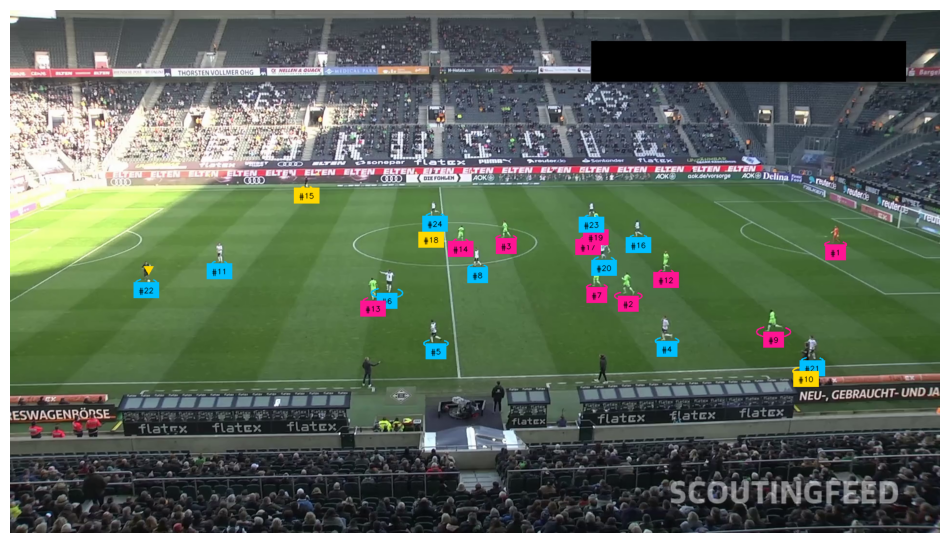

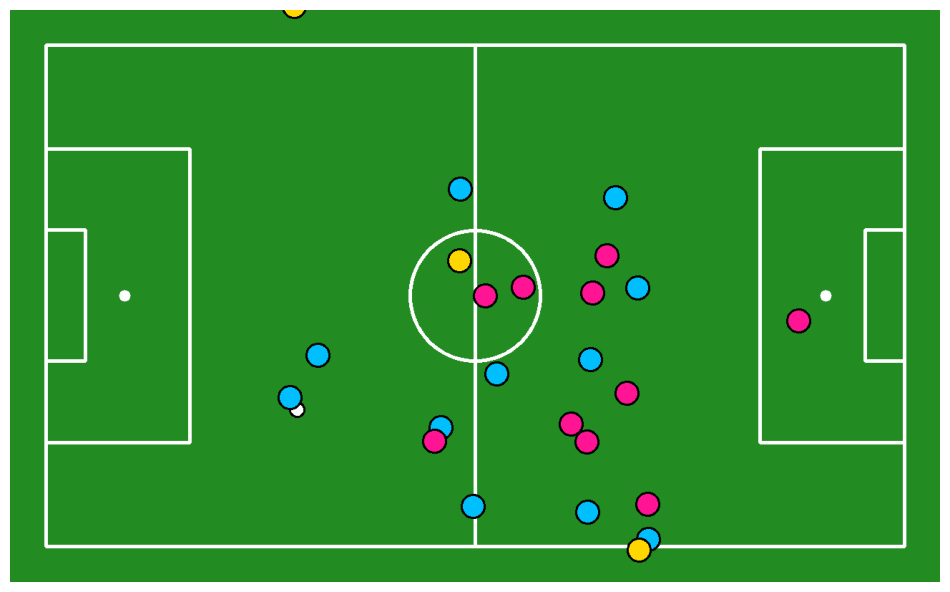

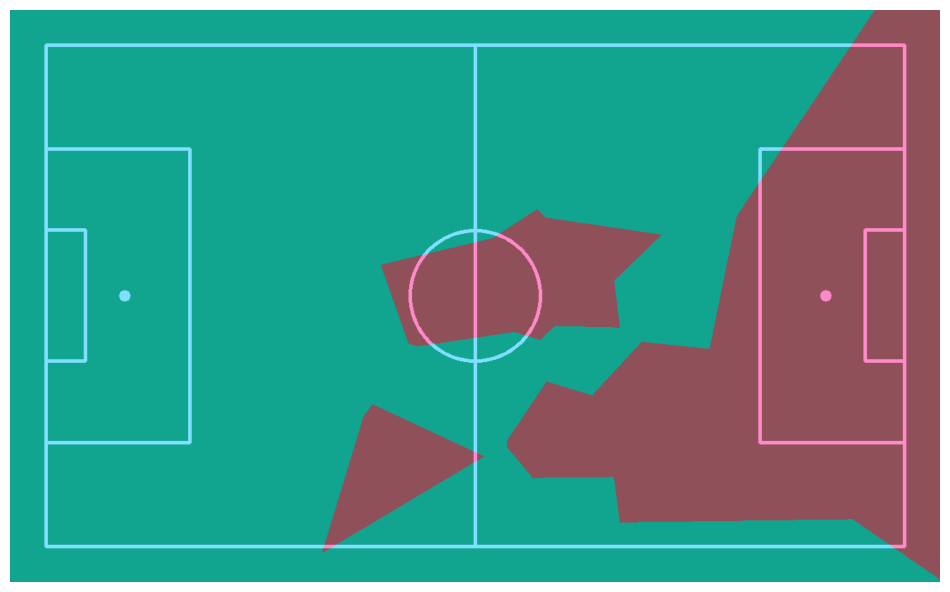

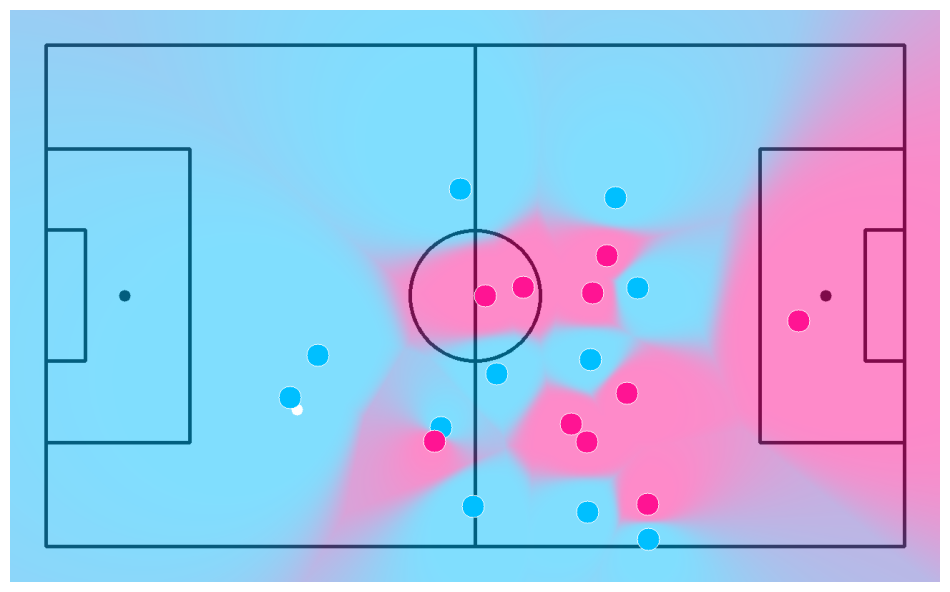

In [ ]:
import supervision as sv
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

SOURCE_VIDEO_PATH = "/content/08fd33_0.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# ball, goalkeeper, player, referee detection

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

# team assignment

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

# frame visualization

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

players_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections
])

# detect pitch key points

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# project ball, players and referies on pitch

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = transformer.transform_points(points=players_xy)

referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = transformer.transform_points(points=referees_xy)

# visualize video game-style radar view

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_referees_xy,
    face_color=sv.Color.from_hex('FFD700'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_pitch_voronoi_diagram(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram with blend

annotated_frame = draw_pitch(
    config=CONFIG,
    background_color=sv.Color.WHITE,
    line_color=sv.Color.BLACK
)
annotated_frame = draw_pitch_voronoi_diagram_2(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.WHITE,
    radius=8,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

视频

In [ ]:
import numpy as np
import supervision as sv
from tqdm import tqdm
import cv2
import contextlib
import io
from google.colab import files #直接下载

# 1. 设置路径
SOURCE_VIDEO_PATH = "/content/08fd33_0.mp4"
TARGET_VIDEO_PATH = "/content/108fd33_0_analysis_result.mp4"
# 定义小地图在主图中的比例 (0.3 表示占宽度的 30%)
MINIMAP_SCALE = 0.35

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# 重置跟踪器
tracker = sv.ByteTrack()
tracker.reset()

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames, desc='生成分析视频'):

        # --- [步骤 1: 模型推理] ---
        # 屏蔽 tqdm 干扰
        with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
            player_result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
            field_result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]

        detections = sv.Detections.from_inference(player_result)
        key_points = sv.KeyPoints.from_inference(field_result)

        # --- [步骤 2: 目标处理与团队分类] ---
        ball_detections = detections[detections.class_id == BALL_ID]
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5)
        all_detections = tracker.update_with_detections(all_detections)

        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        if len(players_detections) > 0:
            crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
            players_detections.class_id = team_classifier.predict(crops)

            if len(goalkeepers_detections) > 0:
                goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

        # --- [步骤 3: 坐标转换 (像素 -> 球场)] ---
        filter = key_points.confidence[0] > 0.5
        if np.sum(filter) >= 4:
            transformer = ViewTransformer(
                source=key_points.xy[0][filter],
                target=np.array(CONFIG.vertices)[filter]
            )

            # 提取球员和球在小地图上的坐标
            combined_players = sv.Detections.merge([players_detections, goalkeepers_detections])
            p_coords = combined_players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
            pitch_players_xy = transformer.transform_points(p_coords)

            b_coords = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
            pitch_ball_xy = transformer.transform_points(b_coords)
        else:
            pitch_players_xy = None

        # --- [步骤 4: 绘制主画面] ---
        annotated_frame = frame.copy()
        # 统一合并用于画椭圆
        final_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=final_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)

        # --- [步骤 5: 绘制小地图并嵌入 (画中画)] ---
        if pitch_players_xy is not None and len(pitch_players_xy) > 0:
            # 绘制你喜欢的平滑维诺图
            minimap = draw_pitch(CONFIG, background_color=sv.Color.WHITE, line_color=sv.Color.BLACK)
            minimap = draw_pitch_voronoi_diagram_2(
                config=CONFIG,
                team_1_xy=pitch_players_xy[combined_players.class_id == 0],
                team_2_xy=pitch_players_xy[combined_players.class_id == 1],
                team_1_color=sv.Color.from_hex('00BFFF'),
                team_2_color=sv.Color.from_hex('FF1493'),
                pitch=minimap
            )
            # 在维诺图上画点
            minimap = draw_points_on_pitch(config=CONFIG, xy=pitch_ball_xy, face_color=sv.Color.WHITE, radius=10, pitch=minimap)

            # 计算缩放比例并覆盖到主图右上角
            mm_h, mm_w, _ = minimap.shape
            target_w = int(video_info.width * MINIMAP_SCALE)
            target_h = int(mm_h * (target_w / mm_w))
            resized_minimap = cv2.resize(minimap, (target_w, target_h))

            # 嵌入位置（右上角，留出 20 像素边距）
            annotated_frame[20:20+target_h, video_info.width-target_w-20:video_info.width-20] = resized_minimap

        # 写入帧
        sink.write_frame(annotated_frame)

files.download(TARGET_VIDEO_PATH)#直接下载

##小地图

In [ ]:
import numpy as np
import supervision as sv
from tqdm import tqdm
import cv2
import contextlib
import io

# --- 配置参数 ---
SOURCE_VIDEO_PATH = "/content/08fd33_0.mp4"
TARGET_VIDEO_PATH = "/content/108fd33_0_analysis_result_2.mp4"
MINIMAP_SCALE = 0.30  # 雷达图占主视频宽度的 30%
MARGIN = 20           # 雷达图距离边缘的像素

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# 重置跟踪器
tracker = sv.ByteTrack()
tracker.reset()

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames, desc='正在合成雷达视频'):

        # 1. 模型推理（屏蔽杂讯输出）
        with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
            player_result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
            field_result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]

        detections = sv.Detections.from_inference(player_result)
        field_key_points = sv.KeyPoints.from_inference(field_result)

        # 2. 球员跟踪与分类
        ball_detections = detections[detections.class_id == BALL_ID]
        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5)
        all_detections = tracker.update_with_detections(all_detections)

        # 区分球队
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        if len(players_detections) > 0:
            crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
            players_detections.class_id = team_classifier.predict(crops)
            if len(goalkeepers_detections) > 0:
                goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

        # 3. 几何变换 (用于生成雷达坐标)
        filter = field_key_points.confidence[0] > 0.5
        radar_ready = False
        if np.sum(filter) >= 4:
            transformer = ViewTransformer(
                source=field_key_points.xy[0][filter],
                target=np.array(CONFIG.vertices)[filter]
            )
            # 获取所有球员和球在平面图上的坐标
            combined_players = sv.Detections.merge([players_detections, goalkeepers_detections])
            pitch_players_xy = transformer.transform_points(combined_players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
            pitch_ball_xy = transformer.transform_points(ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
            pitch_referees_xy = transformer.transform_points(referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
            radar_ready = True

        # 4. 绘制主画面标注
        annotated_frame = frame.copy()
        final_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])
        labels = [f"#{tid}" for tid in final_detections.tracker_id]

        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=final_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=final_detections, labels=labels)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)

        # 5. 绘制雷达图并嵌入
        if radar_ready:
            # 创建雷达图底图 (FIFA 风格：白底黑线或经典绿底)
            radar_view = draw_pitch(CONFIG)

            # 在雷达上画球员
            for team_id, color in [(0, sv.Color.from_hex('00BFFF')), (1, sv.Color.from_hex('FF1493'))]:
                mask = combined_players.class_id == team_id
                if np.any(mask):
                    radar_view = draw_points_on_pitch(
                        config=CONFIG, xy=pitch_players_xy[mask],
                        face_color=color, edge_color=sv.Color.BLACK, radius=12, pitch=radar_view)

            # 画裁判和球
            radar_view = draw_points_on_pitch(config=CONFIG, xy=pitch_referees_xy, face_color=sv.Color.from_hex('FFD700'), radius=12, pitch=radar_view)
            radar_view = draw_points_on_pitch(config=CONFIG, xy=pitch_ball_xy, face_color=sv.Color.WHITE, edge_color=sv.Color.BLACK, radius=8, pitch=radar_view)

            # 缩放雷达图
            mm_h, mm_w, _ = radar_view.shape
            target_w = int(video_info.width * MINIMAP_SCALE)
            target_h = int(mm_h * (target_w / mm_w))
            resized_radar = cv2.resize(radar_view, (target_w, target_h))

            # 覆盖到主画面右上角
            x_offset = video_info.width - target_w - MARGIN
            y_offset = MARGIN
            annotated_frame[y_offset:y_offset+target_h, x_offset:x_offset+target_w] = resized_radar

        # 6. 写入帧
        sink.write_frame(annotated_frame)

print(f"恭喜！战术分析视频已生成：{TARGET_VIDEO_PATH}")

## 足球轨迹

In [ ]:
from collections import deque
import supervision as sv
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch

SOURCE_VIDEO_PATH = "/content/08fd33_0.mp4"
BALL_ID = 0
MAXLEN = 5

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

path_raw = []
M = deque(maxlen=MAXLEN)

for frame in tqdm(frame_generator, total=video_info.total_frames):

    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)

    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )
    M.append(transformer.m)
    transformer.m = np.mean(np.array(M), axis=0)

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

    path_raw.append(pitch_ball_xy)

In [ ]:
path = [
    np.empty((0, 2), dtype=np.float32) if coorinates.shape[0] >= 2 else coorinates
    for coorinates
    in path_raw
]

path = [coorinates.flatten() for coorinates in path]

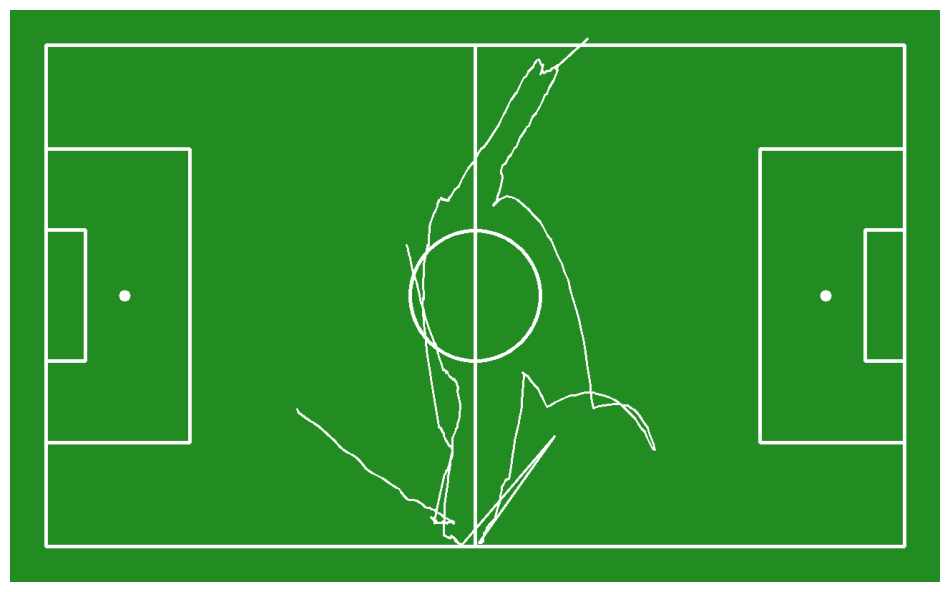

In [ ]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

去除不合理传球（尖峰）

In [ ]:
from typing import List, Union

def replace_outliers_based_on_distance(
    positions: List[np.ndarray],
    distance_threshold: float
) -> List[np.ndarray]:
    last_valid_position: Union[np.ndarray, None] = None
    cleaned_positions: List[np.ndarray] = []

    for position in positions:
        if len(position) == 0:
            # If the current position is already empty, just add it to the cleaned positions
            cleaned_positions.append(position)
        else:
            if last_valid_position is None:
                # If there's no valid last position, accept the first valid one
                cleaned_positions.append(position)
                last_valid_position = position
            else:
                # Calculate the distance from the last valid position
                distance = np.linalg.norm(position - last_valid_position)
                if distance > distance_threshold:
                    # Replace with empty array if the distance exceeds the threshold
                    cleaned_positions.append(np.array([], dtype=np.float64))
                else:
                    cleaned_positions.append(position)
                    last_valid_position = position

    return cleaned_positions

In [ ]:
MAX_DISTANCE_THRESHOLD = 500

path = replace_outliers_based_on_distance(path, MAX_DISTANCE_THRESHOLD)

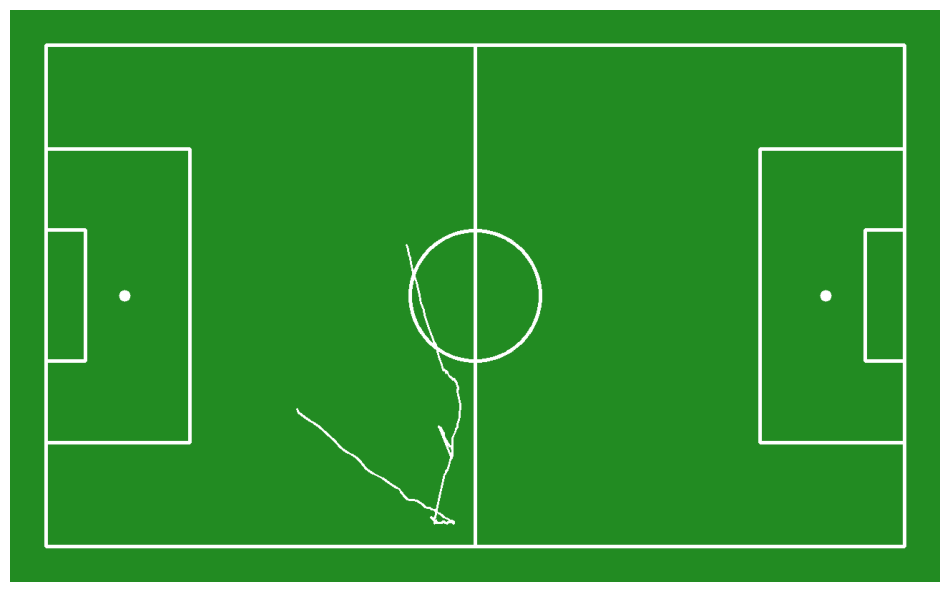

In [ ]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)